In [108]:
%matplotlib inline

import os
import itertools
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import sqrt

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import utils



from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from scipy import signal



# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

In [109]:
d = pd.read_csv('/content/normalized_temp_data_together.csv')
d.pop('Unnamed: 0')
def df_cleaner(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    return df
df = df_cleaner(d)
df = df.set_index(pd.DatetimeIndex(df.DateTime))
df.head()

,DateTime,Henry Hub Price $/MMBtu,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,DOY,Temp,Unnamed: 9,Unnamed: 10
DateTime,,,,,,,,,,
2010-01-01,2010-01-01,5.82,2197157,3117,255035,1666520,1,33.150210,NaN,NaN
2010-02-01,2010-02-01,5.82,2197157,3117,255035,1666520,2,28.389823,NaN,NaN
2010-03-01,2010-03-01,5.82,2197157,3117,255035,1666520,3,26.753999,NaN,NaN
2010-04-01,2010-04-01,6.09,2197157,3117,255035,1666520,4,27.523758,NaN,NaN
2010-05-01,2010-05-01,6.19,2197157,3117,255035,1666520,5,28.425496,NaN,NaN


In [110]:
df['MOY'] =df['DateTime']
def moy(x):
    #test = df_shift_final['DateTime'][x]
    date = datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")
    return date.month
df['MOY'] = df['MOY'].apply(lambda x : moy(x))

df['WOY'] =df['DateTime']
def woy(x):
    #test = df_shift_final['DateTime'][x]
    date = datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")
    return int(date.strftime("%V"))
df['WOY'] = df['WOY'].apply(lambda x : woy(x))
#df.pop('DateTime')
dfw =df.resample('W').mean()
dfw['one_week_back_temp'] = dfw['Temp'].shift(1).fillna(method= 'backfill')
dfw['two_week_back_temp'] = dfw['Temp'].shift(2).fillna(method= 'backfill')
dfw['Consumption MMCF'] = dfw['Consumption MMCF'].apply(lambda x : x/1000)
dfw = dfw.rename(index=str, columns={"Consumption MMCF": "Consumption BCF"})
temp = dfw.reset_index()
dfww = temp.set_index(pd.DatetimeIndex(temp.DateTime))
dfww.pop('DateTime')
matrix = ['Consumption BCF', 'Temp', 'Production MMCF', 'Storage BCFE',
       'MOY', 'WOY']
dff = dfww[matrix]

dff.head()

,Consumption BCF,Temp,Production MMCF,Storage BCFE,MOY,WOY
DateTime,,,,,,
2010-01-03,1978.185000,35.072906,2.179213e+06,2497.000000,1.0,53.0
2010-01-10,2078.133000,67.700595,2.210167e+06,2555.714286,1.0,1.0
2010-01-17,1692.716714,41.030556,2.208424e+06,3157.000000,1.0,2.0
2010-01-24,1666.520000,40.823888,2.197157e+06,2711.142857,1.0,3.0
2010-01-31,1713.513286,33.289143,2.174443e+06,2557.857143,1.0,4.0


In [111]:
def plot_trend_data(ax, column_name, df):
    ax.plot(df.index, df[column_name])
    ax.set_title("Ten years trend of {}".format(column_name))

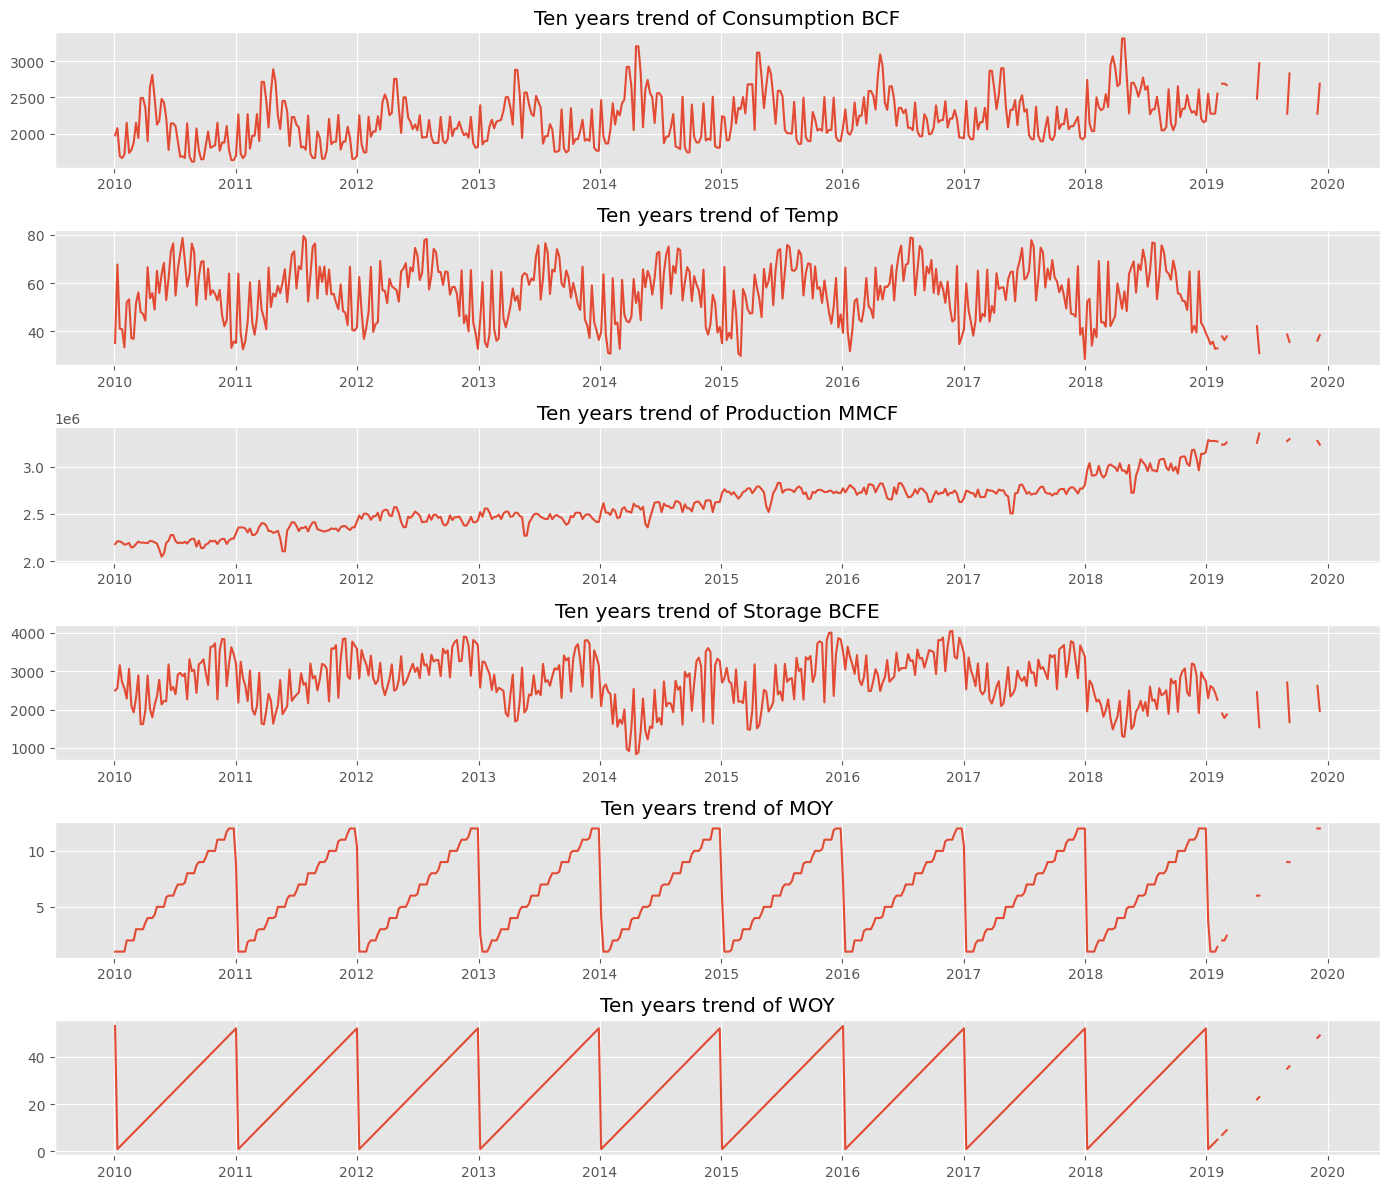

In [112]:
fig, axs = plt.subplots(len(matrix), figsize=(14, 12))

for ax, column_name in zip(axs, matrix):
    plot_trend_data(ax, column_name, dff)

plt.tight_layout()

In [113]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title(" Trend For {}".format(name))

def fit_moving_average_trend(series, window=365):
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=52):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_average_trend)

In [114]:
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

In [115]:
dfrnn = dfww[matrix]

In [116]:
dfrnn.columns

Index(['Consumption BCF', 'Temp', 'Production MMCF', 'Storage BCFE', 'MOY',
       'WOY'],
      dtype='object')

In [117]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -52):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [118]:
values = dfrnn.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 52, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())

    var1(t-52)  var2(t-52)  var3(t-52)  var4(t-52)  var5(t-52)  var6(t-52)  \
52    0.213162    0.130729    0.100785    0.516845         0.0    1.000000   
53    0.272193    0.768357    0.124527    0.535160         0.0    0.000000   
54    0.044558    0.247157    0.123190    0.722727         0.0    0.019231   
55    0.029086    0.243118    0.114548    0.583645         0.0    0.038462   
56    0.056841    0.095870    0.097126    0.535829         0.0    0.057692   

     var1(t)  
52  0.047221  
53  0.383960  
54  0.065539  
55  0.028151  
56  0.054169  


In [119]:
# split into train and test sets
values = reframed.values
n_train_weeks = 308

train = values[:n_train_weeks, :]
test2 = values[n_train_weeks:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test2[:, :-1], test2[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

import numpy as np
import tensorflow as tf
import random

# Set a fixed random seed for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

(308, 1, 6) (308,) (130, 1, 6) (130,)


In [120]:
print(train_X.shape)
print(test_X.shape)



(308, 1, 6)
(130, 1, 6)


Epoch 1/300
5/5 - 11s - loss: 0.3284 - val_loss: 0.4321 - 11s/epoch - 2s/step
Epoch 2/300
5/5 - 0s - loss: 0.3190 - val_loss: 0.4219 - 218ms/epoch - 44ms/step
Epoch 3/300
5/5 - 0s - loss: 0.3081 - val_loss: 0.4091 - 196ms/epoch - 39ms/step
Epoch 4/300
5/5 - 0s - loss: 0.2947 - val_loss: 0.3919 - 127ms/epoch - 25ms/step
Epoch 5/300
5/5 - 0s - loss: 0.2767 - val_loss: 0.3672 - 132ms/epoch - 26ms/step
Epoch 6/300
5/5 - 0s - loss: 0.2511 - val_loss: 0.3295 - 134ms/epoch - 27ms/step
Epoch 7/300
5/5 - 0s - loss: 0.2148 - val_loss: 0.2715 - 131ms/epoch - 26ms/step
Epoch 8/300
5/5 - 0s - loss: 0.1852 - val_loss: 0.2093 - 122ms/epoch - 24ms/step
Epoch 9/300
5/5 - 0s - loss: 0.1708 - val_loss: 0.1757 - 149ms/epoch - 30ms/step
Epoch 10/300
5/5 - 0s - loss: 0.1702 - val_loss: 0.1671 - 128ms/epoch - 26ms/step
Epoch 11/300
5/5 - 0s - loss: 0.1728 - val_loss: 0.1698 - 125ms/epoch - 25ms/step
Epoch 12/300
5/5 - 0s - loss: 0.1617 - val_loss: 0.1766 - 122ms/epoch - 24ms/step
Epoch 13/300
5/5 - 0s - loss

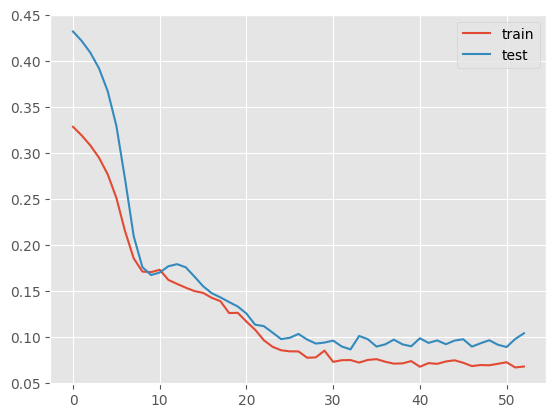

5/5 [==============================] - 0s 5ms/step
Test RMSE: 179.518
R^2 Score: 0.663
Mean Absolute Error (MAE): 145.890
Mean Absolute Percentage Error (MAPE): 6.010


In [121]:
from keras.optimizers import Adam
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_error
from keras.optimizers import RMSprop
from keras.layers import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping

# Design network with batch normalization and L1/L2 regularization
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))


# Use the Adam optimizer with the learning rate specified
optimizer = Adam(learning_rate=0.0005)
model.compile(loss='mae', optimizer=optimizer)


# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)

# Fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=64, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False, callbacks=[early_stopping])

# Evaluate model
yhat = model.predict(test_X)

# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Evaluate model
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# Invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

# Calculate and print RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# Calculate R^2 score
r2 = r2_score(inv_y, inv_yhat)
print('R^2 Score: %.3f' % r2)

# Calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Mean Absolute Error (MAE): %.3f' % mae)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(inv_y, inv_yhat)
print('Mean Absolute Percentage Error (MAPE): %.3f' % mape)

(308, 1, 6) (308,) (130, 1, 6) (130,)


Epoch 1/300
5/5 - 9s - loss: 0.3233 - val_loss: 0.4184 - 9s/epoch - 2s/step
Epoch 2/300
5/5 - 0s - loss: 0.2984 - val_loss: 0.3859 - 145ms/epoch - 29ms/step
Epoch 3/300
5/5 - 0s - loss: 0.2617 - val_loss: 0.3288 - 130ms/epoch - 26ms/step
Epoch 4/300
5/5 - 0s - loss: 0.2053 - val_loss: 0.2311 - 115ms/epoch - 23ms/step
Epoch 5/300
5/5 - 0s - loss: 0.1681 - val_loss: 0.1680 - 131ms/epoch - 26ms/step
Epoch 6/300
5/5 - 0s - loss: 0.1754 - val_loss: 0.1611 - 125ms/epoch - 25ms/step
Epoch 7/300
5/5 - 0s - loss: 0.1641 - val_loss: 0.1768 - 121ms/epoch - 24ms/step
Epoch 8/300
5/5 - 0s - loss: 0.1583 - val_loss: 0.1878 - 113ms/epoch - 23ms/step
Epoch 9/300
5/5 - 0s - loss: 0.1538 - val_loss: 0.1803 - 121ms/epoch - 24ms/step
Epoch 10/300
5/5 - 0s - loss: 0.1476 - val_loss: 0.1619 - 132ms/epoch - 26ms/step
Epoch 11/300
5/5 - 0s - loss: 0.1431 - val_loss: 0.1403 - 125ms/epoch - 25ms/step
Epoch 12/300
5/5 - 0s - loss: 0.1359 - val_loss: 0.1336 - 130ms/epoch - 26ms/step
Epoch 13/300
5/5 - 0s - loss: 

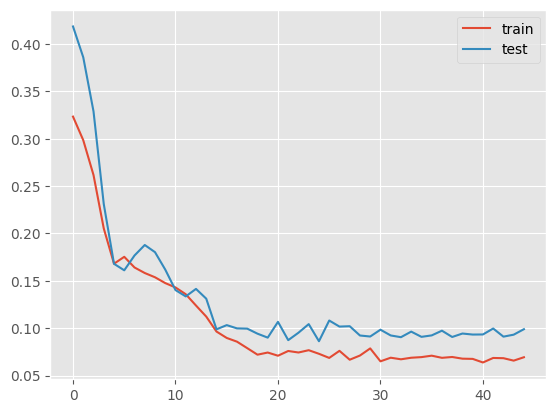

5/5 [==============================] - 0s 5ms/step
Test RMSE: 180.720
R^2 Score: 0.659
Mean Absolute Error (MAE): 146.097
Mean Absolute Percentage Error (MAPE): 5.983


In [122]:
train = values[:n_train_weeks, :]
test2 = values[n_train_weeks:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test2[:, :-1], test2[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


from keras.optimizers import Adam
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_error
from keras.optimizers import RMSprop
from keras.layers import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping

# Design network with batch normalization and L1/L2 regularization
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))
optimizer = Adam(lr=0.0005)  # Adjusting learning rate
model.compile(loss='mae', optimizer=optimizer)

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)

# Fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=64, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False, callbacks=[early_stopping])

# Evaluate model
yhat = model.predict(test_X)

# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Evaluate model
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# Invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

# Calculate and print RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# Calculate R^2 score
r2 = r2_score(inv_y, inv_yhat)
print('R^2 Score: %.3f' % r2)

# Calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Mean Absolute Error (MAE): %.3f' % mae)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(inv_y, inv_yhat)
print('Mean Absolute Percentage Error (MAPE): %.3f' % mape)


